# Bacalhau Unleashed - the 1.4.0 API

## Get node info from API


A Baclahau network is made up of [Nodes](https://docs.bacalhau.org/getting-started/architecture): Compute Nodes and Requester Nodes. Understanding how these nodes are related to one another is super-helpful in helping us conceptualise the nature of Distributed Computing networks, and we can get this information from the `/api/v1/orchestrator/nodes` endpoint.

First, let's install the dependencies we'll need for this network.

In [1]:
!pip install networkx
!pip install matplotlib

In this cell, we're generating a HTTP request to the Requester node of a Bacalhau Network to get the information about all of the nodes connected to it.

This data will return a JSON payload, which we can then use to visualise the structure of our network.

In [14]:
import os
import requests
import pprint
import json
import time

REQUESTER_HOST = "bootstrap.production.bacalhau.org"
REQUESTER_API_PORT = "1234"

try:
  REQUESTER_HOST = os.environ["BACALHAU_API_HOST"]
  REQUESTER_API_PORT = os.environ['REQUESTER_API_PORT']
except KeyError as e:
    missing_var = e.args[0]
    print(f"Error: The environment variable '{missing_var}' is not set.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

REQUESTER_BASE_URL = f"http://{REQUESTER_HOST}:{REQUESTER_API_PORT}"

getNodesInNetworkResp = requests.get(REQUESTER_BASE_URL + "/api/v1/orchestrator/nodes")
nodes_data = None

# Check if the request was successful
if getNodesInNetworkResp.status_code == 200:
    # Parse the JSON response
    nodes_data = getNodesInNetworkResp.json()

    # Pretty print the JSON data
    pprint.pprint(nodes_data)
else:
    print(f"Failed to retrieve nodes. HTTP Status code: {getNodesInNetworkResp.status_code}")
    print(f"Response: {getNodesInNetworkResp.text}")

Error: The environment variable 'BACALHAU_API_HOST' is not set.
{'NextToken': '',
 'Nodes': [{'Connection': 'CONNECTED',
            'Info': {'BacalhauVersion': {'BuildDate': '0001-01-01T00:00:00Z',
                                         'GOARCH': '',
                                         'GOOS': '',
                                         'GitCommit': '',
                                         'GitVersion': ''},
                     'ComputeNodeInfo': {'AvailableCapacity': {'CPU': 12.8,
                                                               'Disk': 1676877044121,
                                                               'Memory': 53930662297},
                                         'EnqueuedExecutions': 0,
                                         'ExecutionEngines': ['wasm', 'docker'],
                                         'MaxCapacity': {'CPU': 12.8,
                                                         'Disk': 1676877044121,
                             

## Render Network

Now that we have the information on our network structure, we can write use `matplotlib` and `networkx` to visualise it.

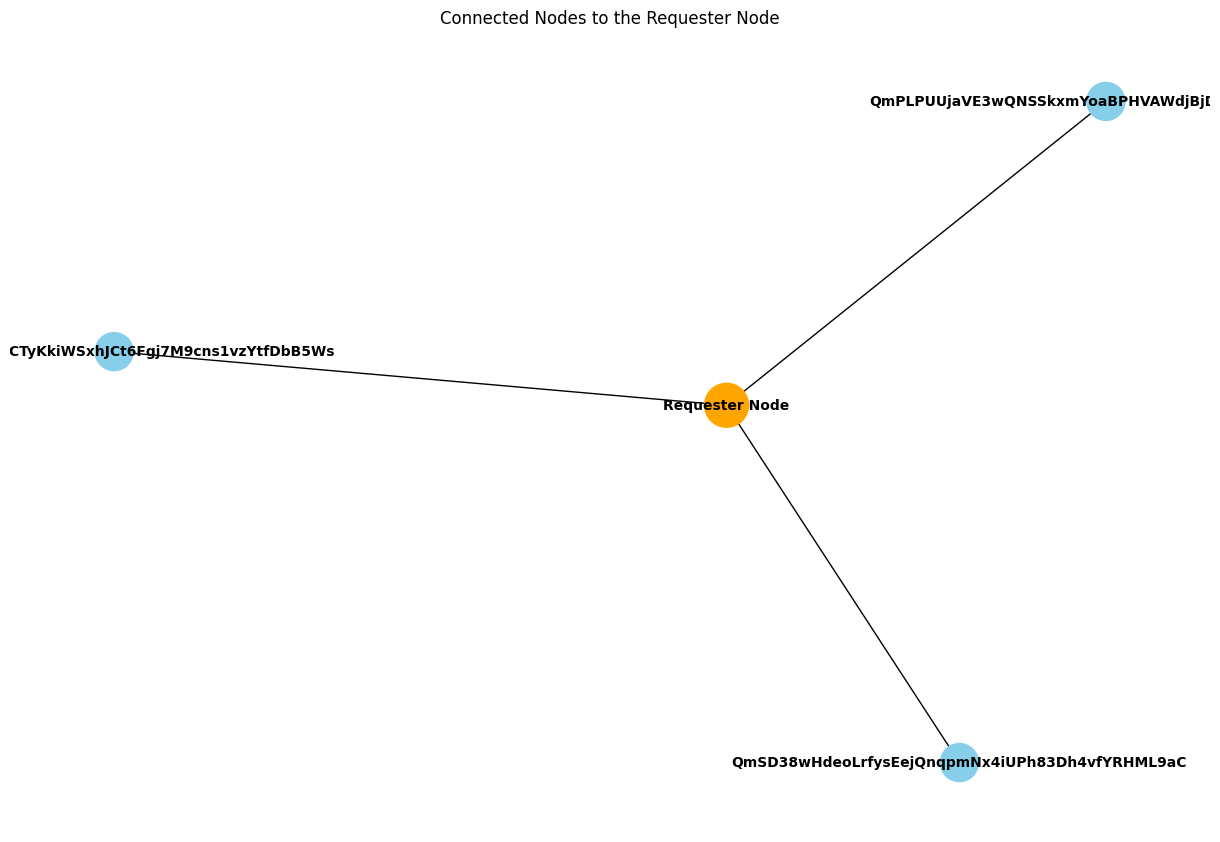

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

# Function to truncate NodeID to only show up to the second hyphen
def truncate_node_id(node_id):
    parts = node_id.split('-')
    return '-'.join(parts[:2]) if len(parts) > 3 else node_id

# Find the requester node
requester_node = None
for node in nodes_data['Nodes']:
    if node['Info']['NodeType'] == 'Requester':
        requester_node = truncate_node_id(node['Info']['NodeID'])
        break

if requester_node is None:
    requester_node = 'Requester Node'  # Fallback in case no requester node is found
G.add_node(requester_node, label=requester_node)

# Add the connected nodes
for node in nodes_data['Nodes']:
    if node['Connection'] == 'CONNECTED':
        truncated_node_id = truncate_node_id(node['Info']['NodeID'])
        G.add_node(truncated_node_id, label=truncated_node_id)
        G.add_edge(requester_node, truncated_node_id)

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_node_attributes(G, 'label')

# Draw the nodes with customized colors and sizes
node_colors = ['orange' if node == requester_node else 'skyblue' for node in G.nodes()]
node_sizes = [1000 if node == requester_node else 750 for node in G.nodes()]  # Reduce size by 50%

nx.draw(G, pos, labels=labels, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10, font_weight='bold')
plt.title('Connected Nodes to the Requester Node')
plt.show()

# Creating a Job

Creating a [Job](https://docs.bacalhau.org/references/jobs/task/job) is simple. We can create a JSON payload which describes the Job, it's requirements, and the tasks it must complete for dispatching to the Bacalhau network.

Once the Job is dispatched, we'll get a response from the Bacalhau network giving us a Job ID that we can use to retrieve further information on the state of our Job, and any output it may have generated.

In [16]:
import requests
import pprint
import json

job = '''
{
  "Job": {
    "Name": "test-job",
    "Type": "batch",
    "Count": 1,
    "Labels": {
      "foo": "bar",
      "env": "dev"
    },
    "Tasks": [
      {
        "Name": "task1",
        "Engine": {
          "Type": "docker",
          "Params": {
            "Image": "ubuntu:latest",
            "Entrypoint": [
              "echo",
              "hello, world"
            ]
          }
        },
        "Publisher": {
          "Type": "noop"
        }
      }
    ],
    "CreateTime": 1234
  }
}
'''

createJobResp = requests.put(REQUESTER_BASE_URL + "/api/v1/orchestrator/jobs", json=json.loads(job))
createJobRespData = None

if createJobResp.status_code == 200:
    # Parse the JSON response
    createJobRespData = createJobResp.json()
    pprint.pprint(createJobRespData)
else:
    print(f"Failed to retrieve nodes. HTTP Status code: {createJobResp.status_code}")
    print(f"Response: {createJobResp.text}")

{'EvaluationID': '851e4f04-2a6c-438f-88f7-b25e112d6fa2',
 'JobID': 'j-aba20b3f-a8f2-436f-88b5-1beaf7d9bca4',
 'Warnings': ['job create time is ignored when submitting a job']}


## Get Job Results

Now that we’ve submitted a Job, we can get the results of that execution. And it’s super simple to do so! All we need is to pass the value of the JobID key that we received once we created our job to the `/api/v1/orchestrator/jobs/{job_id}/results` endpoint.


In [17]:
job_id = createJobRespData["JobID"]

pprint.pprint(job_id)

createJobResp = requests.get(f"{REQUESTER_BASE_URL}/api/v1/orchestrator/jobs/{job_id}/results")

if createJobResp.status_code == 200:
    # Pretty print the JSON data
    pprint.pprint(createJobResp.json())
else:
    print(f"Failed to retrieve nodes. HTTP Status code: {createJobResp.status_code}")
    print(f"Response: {createJobResp.text}")

'j-aba20b3f-a8f2-436f-88b5-1beaf7d9bca4'
{'Items': [], 'NextToken': ''}


But wait! Where are our results? Well, when we created our job, we didn't specify a publisher to send our results to. This doesn't mean that we span one up for nothing, though. The output of each Job is still stored in our network, and we can retrieve those by accessing our Job `executions`.

## Get Execution Results of Job

With the `api/v1/orchestrator/jobs/{job_id}/executions` endpoint, we can get a list of all of the executions of our Job that have taken place so far!

In [18]:
import time
time.sleep(5)
getJobExecResp = requests.get(f"{REQUESTER_BASE_URL}/api/v1/orchestrator/jobs/{job_id}/executions")
getJobExecRespData = None

if getJobExecResp.status_code == 200:
    # Pretty print the JSON data
    pprint.pprint(getJobExecResp.json())
    getJobExecRespData = getJobExecResp.json()

    for item in getJobExecRespData.get("Items", []):
      print(f"Execution ID: {item['ID']}")

      if item["RunOutput"] != None:
        print("Stdout:")
        print(item["RunOutput"]["Stdout"])
        print("-" * 20)  # Separator for readability
      else:
        print(f"No data returned at this point for execution {item['ID']}")

else:
    print(f"Failed to retrieve nodes. HTTP Status code: {createJobResp.status_code}")
    print(f"Response: {createJobResp.text}")


{'Items': [{'AllocatedResources': {'Tasks': {}},
            'ComputeState': {'Message': 'Accepted job', 'StateType': 7},
            'CreateTime': 1720199565754869770,
            'DesiredState': {'Message': 'execution completed', 'StateType': 2},
            'EvalID': '851e4f04-2a6c-438f-88f7-b25e112d6fa2',
            'FollowupEvalID': '',
            'ID': 'e-b7e4f88c-f1b9-45fa-b3b9-34f1287beb32',
            'JobID': 'j-aba20b3f-a8f2-436f-88b5-1beaf7d9bca4',
            'ModifyTime': 1720199566104519761,
            'Name': '',
            'Namespace': 'default',
            'NextExecution': '',
            'NodeID': 'QmbxGSsM6saCTyKkiWSxhJCt6Fgj7M9cns1vzYtfDbB5Ws',
            'PreviousExecution': '',
            'PublishedResult': {'Type': ''},
            'Revision': 6,
            'RunOutput': {'ErrorMsg': '',
                          'ExitCode': 0,
                          'StderrTruncated': False,
                          'Stdout': 'hello, world\n',
                      